In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import quantize_nbit,print_nowrap,create_data_to_verilog

## Dataset
MNIST is a dataset of 70,000 handwritten images. The input are 28 pixels by 28 pixels images. They are represented in grayscale, 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0
x_test  /= 255.0

## Construct the NN model

Our NN will have the following structure
1. **AveragePooling:** This layer turns a 28x28 image to 14x14. It takes the input image and transforms each 4x4 sub-matrix by replacing it with its average value.
2. **Flatten:** This layer converts a 14x14 matrix to a 196x1 1D vector. This conversion is needed for the next layers.
3. **Dense layer 1:** In a dense layer (also known as a fully connected layer), the output of each neuron is calculated by a weighted sum of the inputs from all neurons in the preceding layer. This sum is passed through an activation function before being propagated to the next layer.
4. **Dense layer 2:** The output layer has 10 neurons: one for each of the possible digit. The neuron with the largest value corresponds to the recognized digit.

In [3]:
# Importing Keras model and layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, AveragePooling2D

# Construct the NN by stacking all required layers
model_s_nn = Sequential() # Sequential: the layers will be connected to one another
model_s_nn.add(AveragePooling2D(pool_size=(2, 2), input_shape=(28, 28, 1)))
model_s_nn.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model_s_nn.add(Dense(32, activation=tf.nn.relu))
model_s_nn.add(Dense(10,activation=tf.nn.softmax))
model_s_nn.summary() # Print NN summary

c:\Users\jzlco\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\pooling\base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ average_pooling2d               │ (None, 14, 14, 1)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,634 (25.91 KB)

 Trainable params: 6,634 (25.91 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

The model can now be trained using the training dataset. For each image x_train(i), the model will try to find the associated digit y_train(i). It will gradually adjust the values for the different weights and biases of the dense layers.

In [4]:
# Train the model
model_s_nn.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model_s_nn.fit(x=x_train,y=y_train,validation_data=(x_test, y_test) epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7584 - loss: 0.8749
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9229 - loss: 0.2711
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9369 - loss: 0.2235
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9453 - loss: 0.1890
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9524 - loss: 0.1674
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9563 - loss: 0.1523
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9590 - loss: 0.1421
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9602 - loss: 0.1346
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9635 - loss: 0.1238
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9670 - loss: 0.1130


As we can see, our model performs well on unseen data. We will now turn the biases and weights to Verilog vectors.

## Explore the weights used by the model and Quantize
The trained model has a set of weights and biases for each neuron. The output of a neuron is being calculated as: out(n)=Sum(wn(k)*in(k))+b(n).
<br>A 5 neurons layer which takes into input a vector of 20 elements has:
* 5 biases, one per neuron
* 20*5 weights, 20 per neuron
<br><br>
Those biases and neurons are coded as floats, which would take too much space. We will reduce these to 8 bits so that it can be stored into our board.
<br> The verilog arrays generated are indexed as follows:  array_layer[neuron_num][weight_num]


In [9]:
# Quantize and Export the weights
n_bit               = 8            # Number of bits to quantize to
quantized_wb        = []
quantized_wb_scale  = []

print(model_s_nn.layers)

for l,layer in enumerate(model_s_nn.layers):
    if len(layer.weights)>0:
        w,b = layer.weights
        w,b = w.numpy(), b.numpy()
        print('Layer {} - Array Shape/Range: Weights = {}, Biases = {}'.format(l, w.shape, b.shape))
        w_q, w_qi, scale = quantize_nbit(w, n_bit, verbose=1)
        b_q, b_qi, _     = quantize_nbit(b, n_bit, use_scale=scale)
        
        # Print the scaled values
        num_w, num_neuron = w.shape
        
        # Print the Biases as an SV parameter array
        s = "localparam signed [{}:0] B_ARRAY_L{} [0:{}] = '{{ {} }};".format(n_bit-1, l, num_neuron-1, ', '.join(str(int(e)) for e in b_qi))
        print_nowrap(s)
        
        # Print Weights as an SV parameter array
        s = "localparam signed [{}:0] W_ARRAY_L{} [0:{}] [0:{}] = '{{<br>".format(n_bit-1, l, num_neuron-1, len(w_qi[:,0])-1)
        for n in range(num_neuron) :
            s += "{{ {} }},<br>".format(', '.join(str(int(e)) for e in w_qi[:,n]))
        s = s[0:-5] # remove last comma
        s += "<br>};<br>"
        print_nowrap(s)

        quantized_wb.append((w_qi, b_qi))
        quantized_wb_scale.append((w_q,  b_q))
        

[<AveragePooling2D name=average_pooling2d, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]
Layer 2 - Array Shape/Range: Weights = (196, 32), Biases = (32,)
Quantizing to +/- 127, scaling by 66.64247581601991


Layer 3 - Array Shape/Range: Weights = (32, 10), Biases = (10,)
Quantizing to +/- 127, scaling by 51.265423057441645


The weights and biases are available above and can be added to the Verilog code. 

## Creation of test vectors

This function transform images in test vectors to be used in the Verilog code.

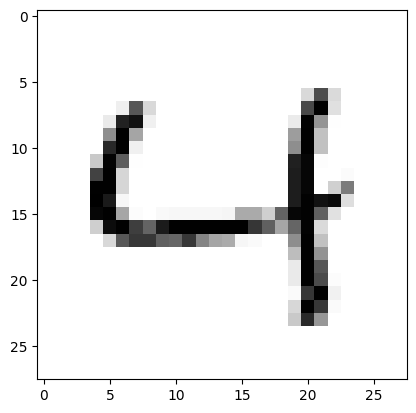

In [8]:
test_data, test_data_int = create_data_to_verilog(8,x_train[1440],show_img=1)